Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

print("Libraries loaded.")


Libraries loaded.


Load dataset

In [ ]:
import os
os.listdir()


['.config', 'database.csv', 'rf_seismic_model.pkl', 'sample_data']

In [ ]:
import pandas as pd
df = pd.read_csv("database.csv")
df.head()


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


Normalize columns

In [ ]:
# column normalize
df.columns = [c.strip() for c in df.columns]
df = df.rename(columns={c: c.lower().replace(" ", "_") for c in df.columns})

lat_cols = [c for c in df.columns if 'lat' in c]
lon_cols = [c for c in df.columns if 'lon' in c]
depth_cols = [c for c in df.columns if 'depth' in c]
mag_cols = [c for c in df.columns if 'mag' in c]
date_cols = [c for c in df.columns if 'date' in c]
time_cols = [c for c in df.columns if 'time' in c]

lat_cols, lon_cols, depth_cols, mag_cols, date_cols, time_cols


(['latitude'],
 ['longitude'],
 ['depth', 'depth_error', 'depth_seismic_stations'],
 ['magnitude',
  'magnitude_type',
  'magnitude_error',
  'magnitude_seismic_stations',
  'magnitude_source'],
 ['date'],
 ['time'])

Final columns

In [ ]:
# first valid
lat_col = lat_cols[0]
lon_col = lon_cols[0]
mag_col = mag_cols[0]
depth_col = depth_cols[0] if depth_cols else None

# datetime
if date_cols and time_cols:
    df['event_datetime'] = pd.to_datetime(df[date_cols[0]] + " " + df[time_cols[0]], errors='coerce')
else:
    df['event_datetime'] = pd.to_datetime(df[date_cols[0]], errors='coerce')

df['year'] = df['event_datetime'].dt.year.fillna(-1).astype(int)
df['month'] = df['event_datetime'].dt.month.fillna(-1).astype(int)
df['day'] = df['event_datetime'].dt.day.fillna(-1).astype(int)
df['hour'] = df['event_datetime'].dt.hour.fillna(-1).astype(int)

df[[lat_col, lon_col, depth_col, mag_col, 'year','month','day','hour']].head()


,latitude,longitude,depth,magnitude,year,month,day,hour
0,19.246,145.616,131.6,6.0,1965,1,2,13
1,1.863,127.352,80.0,5.8,1965,1,4,11
2,-20.579,-173.972,20.0,6.2,1965,1,5,18
3,-59.076,-23.557,15.0,5.8,1965,1,8,18
4,11.938,126.427,15.0,5.8,1965,1,9,13


Risk Level

In [ ]:
# magnitude -> numeric
df[mag_col] = pd.to_numeric(df[mag_col], errors='coerce')
def mag_to_risk(m):
    if pd.isna(m):
        return np.nan
    if m < 4:
        return 0   # low
    elif m <= 6:
        return 1   # moderate
    else:
        return 2   # high

df['risk_level'] = df[mag_col].apply(mag_to_risk)

df['risk_level'].value_counts(dropna=False)


,count
risk_level,
1,17638
2,5774


Model dataset

In [ ]:
feature_cols = [lat_col, lon_col, depth_col, 'year','month','day','hour']

for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df_model = df.dropna(subset=[lat_col, lon_col, 'risk_level']).copy()

if depth_col:
    df_model[depth_col] = df_model[depth_col].fillna(df_model[depth_col].median())

df_model[feature_cols + ['risk_level']].head()


,latitude,longitude,depth,year,month,day,hour,risk_level
0,19.246,145.616,131.6,1965,1,2,13,1
1,1.863,127.352,80.0,1965,1,4,11,1
2,-20.579,-173.972,20.0,1965,1,5,18,2
3,-59.076,-23.557,15.0,1965,1,8,18,1
4,11.938,126.427,15.0,1965,1,9,13,1


EDA

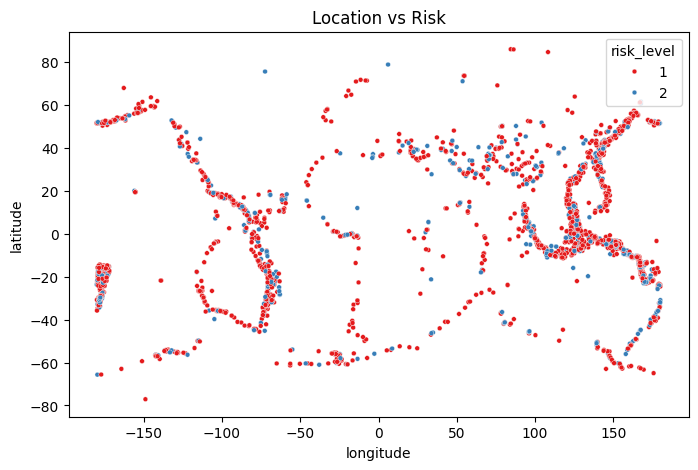

In [ ]:
df_model['risk_level'].value_counts()

import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_model.sample(3000), x=lon_col, y=lat_col, hue='risk_level', palette='Set1', s=12)
plt.title("Location vs Risk")
plt.show()


Train/Test Split

In [ ]:
X = df_model[feature_cols].values
y = df_model['risk_level'].astype(int).values

# SMOTE applied
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("After SMOTE class distribution:", np.bincount(y_res))

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.20, random_state=42, stratify=y_res
)

X_train.shape, X_test.shape


After SMOTE class distribution: [    0 17638 17638]


((28220, 7), (7056, 7))

In [ ]:
#hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

param_dist = {
    'n_estimators':[50,100,200],
    'max_depth':[None,10,20,30],
    'min_samples_split':[2,5,10]
}
rs = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                        param_distributions=param_dist,
                        n_iter=8, scoring='f1_macro', cv=StratifiedKFold(3), random_state=1, n_jobs=-1)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
clf = rs.best_estimator_


Best params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 30}


Training RandomForest Classifier

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Evaluation

Accuracy: 0.8173185941043084
              precision    recall  f1-score   support

           1       0.80      0.85      0.82      3528
           2       0.84      0.79      0.81      3528

    accuracy                           0.82      7056
   macro avg       0.82      0.82      0.82      7056
weighted avg       0.82      0.82      0.82      7056



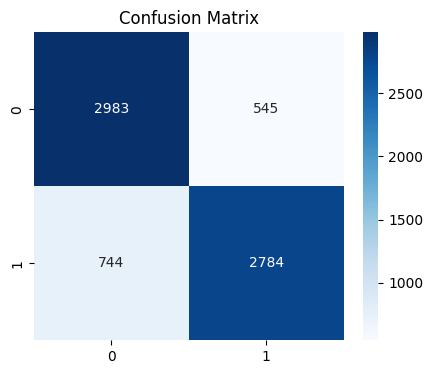

,feature,importance
4,month,0.155442
2,depth,0.155246
1,longitude,0.148972
0,latitude,0.145081
3,year,0.139386
5,day,0.128768
6,hour,0.127104


In [ ]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

fi = pd.DataFrame({'feature': feature_cols, 'importance': clf.feature_importances_}).sort_values('importance', ascending=False)
fi


Save Model

In [ ]:
joblib.dump({'model': clf, 'features': feature_cols}, "rf_seismic_model.pkl")


['rf_seismic_model.pkl']

Sample Predictions

In [ ]:
sample = df_model.sample(8).copy()
sample['predicted_risk'] = clf.predict(sample[feature_cols].values)
sample[[*feature_cols, 'risk_level', 'predicted_risk']]


,latitude,longitude,depth,year,month,day,hour,risk_level,predicted_risk
10704,45.521000,151.707000,18.700,1991,12,13,18,2,2
8092,37.566667,-118.438167,5.044,1986,7,20,14,1,1
11557,0.711000,-25.956000,14.900,1993,8,15,3,1,1
1538,-5.632000,-80.200000,73.100,1970,3,31,8,1,1
6523,51.976000,179.259000,116.100,1983,4,3,19,1,1
17077,-15.873000,-174.631000,227.800,2004,12,20,7,1,1
7091,36.471000,70.906000,203.800,1984,7,1,10,1,1
2628,50.078000,156.936000,48.000,1973,2,28,6,1,1


Correlation Heatmap

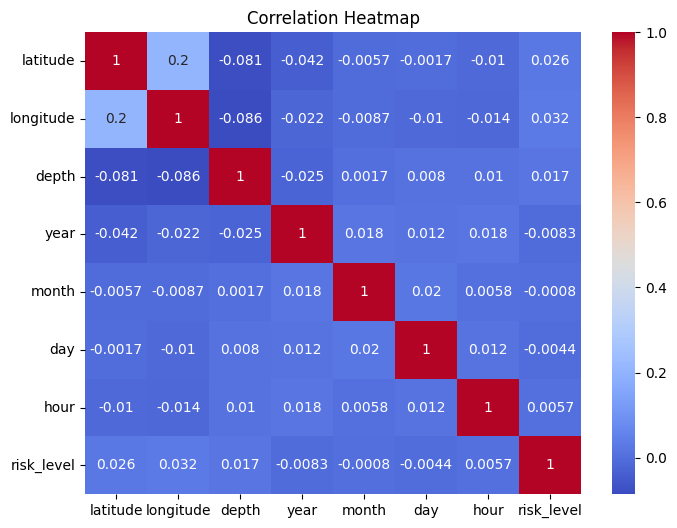

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df_model[feature_cols + ['risk_level']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Folium Interactive Map

In [ ]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[df_model[lat_col].mean(), df_model[lon_col].mean()], zoom_start=2)
cluster = MarkerCluster().add_to(m)

# sample
sample_map = df_model.sample(min(3000, len(df_model)), random_state=1)

for _, row in sample_map.iterrows():
    col = "green" if row['risk_level']==0 else "orange" if row['risk_level']==1 else "red"
    folium.CircleMarker(
        location=[row[lat_col], row[lon_col]],
        radius=3,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7
    ).add_to(cluster)

m
